In [1]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk

In [3]:
# %%
cli = MongoClient("localhost",27017)
db = cli.yelp
cursor = db.user.find({}, {"review_count" : 1, "user_id" : 1}).limit(10000).sort("review_count", -1)
# %%
yelp_users_by_rating = pd.DataFrame(list(cursor))
n, bins, patches = plt.hist(yelp_users_by_rating['review_count'], 50, normed=0, facecolor='green', alpha=0.75)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')
plt.title('Number of reviews for most active users')

Just as we suspected, most users review far less than 1000 places.
This is without even filtering out restaraunts, so what can be done to stimulate activity on yelp?

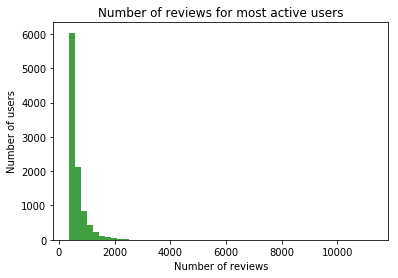

In [4]:
#Note: Save this to a png!
plt.show()

Analyzing behaviour of frequent raters.
Sentiment of their ratings? Do they mostly rate when bad or good, or both?
First query reviews of top 100 frequent raters.

In [9]:
#%%
top_user_ids = yelp_users_by_rating[1:10001]['user_id'].values.tolist()
top_user_ids
review_collection = db.get_collection('review')
review_collection.count()
relevent_reviews = review_collection.find({"user_id" :  {"$in" : top_user_ids } })
relevent_reviews_df = pd.DataFrame(list(relevent_reviews))

In [10]:
#%%
def calculate_average_sentiment(string):
    blob = TextBlob(string)
    init = 0
    for sentence in blob.sentences:
        init += sentence.sentiment.polarity
    return (init)/len(blob.sentences)

Looks like most of the top reviewers mostly when they have positive things to say about the business. About one quarter of the relevant reviews have positive sentiment detected in the content of the review. While less than 1% of the relevant reviews have negative sentiment detected in the review.

In [11]:
relevent_reviews_df['sentiment'] = relevent_reviews_df['text'].map(calculate_average_sentiment)

countHigh = len(relevent_reviews_df[relevent_reviews_df['sentiment'] > 0.25])
countLow = len(relevent_reviews_df[relevent_reviews_df['sentiment'] < -0.25])

print("Number of reviews with high sentiment score: %d" %(countHigh))
print("Number of reviews with low sentiment score: %d" %(countLow))

print("Percent of relevant reviews with high sentiment scores: %.2f" %(countHigh/(len(relevent_reviews_df))*100))
print("Percent of relevant reviews with low sentiment scores: %.2f" %(countLow/(len(relevent_reviews_df))*100))

Number of reviews with high sentiment score: 105228
Number of reviews with low sentiment score: 1416
Percent of relevant reviews with high sentiment scores: 26.96
Percent of relevant reviews with low sentiment scores: 0.36


Lets see if the review distribution of these users matches the polarity distribution we just calculated.

In [12]:
starsHigh = len(relevent_reviews_df[relevent_reviews_df['stars'] > 4.0])
starsLow = len(relevent_reviews_df[relevent_reviews_df['stars'] < 2.0])

print("Number of reviews with more than 4 stars: %d" %(starsHigh))
print("Number of reviews with less than 2 stars: %d" %(starsLow))

print("Percent of relevant reviews with high star ratings: %.2f" %(starsHigh/len(relevent_reviews_df)*100))
print("Percent of relevant reviews with low star ratings: %.2f" %(starsLow/len(relevent_reviews_df)*100))

Number of reviews with more than 4 stars: 87655
Number of reviews with less than 2 stars: 14251
Percent of relevant reviews with high star ratings: 22.46
Percent of relevant reviews with low star ratings: 3.65


This is somewhat similar but not as close as we would like to have seen.

In [13]:
normalizedSentiment = []
normalizedStars = []

for sentimentVal in relevent_reviews_df['sentiment']:
    normVal = (sentimentVal + 1)/2
    normalizedSentiment.append(normVal)
    
for starVal in relevent_reviews_df['stars']:
    normVal = (starVal-1)/4
    normalizedStars.append(normVal)
    
xvals = np.linspace(0, 1, 13377)

To visualize this comparison between stars and sentiment, it would be easier to show this on a line plot. First, both values will need to be normalized between 0 and 1 to be on the same scale. This is done by creating two new arrays for normalized values

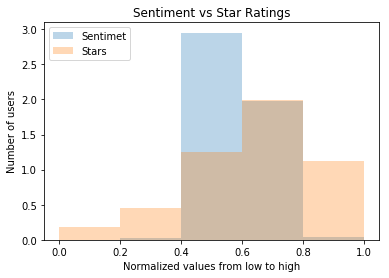

In [14]:
plt.hist(normalizedSentiment, 5, normed=1, alpha=0.3, label='Sentimet')
plt.hist(normalizedStars, 5, normed=1, alpha=0.3, label='Stars')
plt.legend(loc='upper left')
plt.xlabel('Normalized values from low to high')
plt.ylabel('Number of users')
plt.title('Sentiment vs Star Ratings')
plt.show()

Using 5 bins. We can match up sentiment values to the star ratings for each review. The Star data follows a nice bell curve with most reviews around 4 stars. The sentiment data is more condensed around the neutral to slightly positive range. From this, we can see that while users might give poor numerical ratings for a business, they usually don't say a lot of negative things about the business.

In [ ]:
business_collection = db.business

In [ ]:
##So looks like 33.7% of the businesses in this dataset are Restaraunts
business_collection.find({"categories": "Restaurants"}).count()/business_collection.count()
relevent_business_ids = business_collection.find({"categories": "Restaurants"}, {"business_id" : 1})
relevent_id_df = pd.DataFrame(list(relevent_business_ids))
relevent_ids = relevent_id_df['business_id'].values.tolist()

In [ ]:
relevent_restaraunt_reviews = review_collection.find({"business_id" :  {"$in" : relevent_ids } }).limit(200000)

In [ ]:
restaurant_review_df = pd.DataFrame(list(relevent_restaraunt_reviews))
restaurant_review_df

In [ ]:
restaurant_review_df['sentiment'] = restaurant_review_df['text'].map(calculate_average_sentiment)
sentiments = restaurant_review_df['sentiment']
ratings = restaurant_review_df['stars']

In [ ]:
from scipy.stats import pearsonr
#Pretty good positive correlation between sentiment and rating
pearsonr(sentiments, ratings)
#The csv modified_reviews is generated by the following code.
#It is then read from the csv instead of passing around the dataframe, since this is an expensive calculation
#to do each time
'''
user_collection = db.user
def lookup_user_property(user_id, key):
    return list(user_collection.find({"user_id": user_id}, {key: 1}))[0][key]
    
restaurant_review_df['compliment_funny'] = restaurant_review_df['user_id'].apply(lookup_user_property, args=('compliment_funny',))
restaurant_review_df['compliment_more'] = restaurant_review_df['user_id'].apply(lookup_user_property, args=('compliment_more',))
restaurant_review_df['compliment_writer'] = restaurant_review_df['user_id'].apply(lookup_user_property, args=('compliment_writer',))
restaurant_review_df.to_csv('finalcsv.csv')
'''

